In [1]:
import pylab                 as pl
import numpy                 as np
import pandas                as pd
import os
from   astropy.io            import fits
from   astropy.table         import Table
from   astropy.coordinates   import SkyCoord
from   astropy.cosmology     import WMAP9 as cosmo
from   astropy.cosmology     import z_at_value
from   astropy               import units as u
from   glob                  import glob
from   matplotlib.ticker     import FormatStrFormatter

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'figure.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [3]:
#- Function to convert from ra dec z to x,y,z cartesian using WMAP9 cosmology
def radecz2xyz(ra,dec,z):
    distance = cosmo.comoving_distance(np.array(z)) 
    c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=distance, frame='icrs')
    return c.cartesian.x.to_value(), c.cartesian.y.to_value(), c.cartesian.z.to_value()

#- Compute the disperse filaments
def compute_disperse(file):
    xyzfile = f'{file[:-4]}_xyz.txt'
    np.savetxt(f'./data/{xyzfile}', np.c_[np.arange(len(X),dtype=int), X,Y,Z], header='id px py pz', fmt='%d %f %f %f')
    
    os.chdir('/mnt/d/UDrive/Uniandes/Doctorado/TG/Projects/BGSENV/alignment_cw/')
    path = '../../alignment_cw/data/'
    delaunay_command = f'./delaunay_3D {path}{xyzfile} -btype smooth -outDir {path}'
    mse_command      = f'./mse {path}{xyzfile}.NDnet -dumpManifolds J2ad -upSkl -forceLoops -nsig 2 -outDir {path}'
    skle_command     = f'./skelconv {path}{xyzfile}.NDnet_s2.up.NDskl -smooth 1 -to NDskl_ascii -outDir {path}'

    os.chdir('/mnt/d/UDrive/Uniandes/Doctorado/TG/Projects/BGSENV/DisPerSE/bin/')
    os.system(delaunay_command)
    os.system(mse_command)
    os.system(skle_command)
    os.chdir('/mnt/d/UDrive/Uniandes/Doctorado/TG/Projects/BGSENV/alignment_cw/')
    
#- Get the id for each filament
def get_ID_FILA(pos,L):
    total = 0
    for i,l in enumerate(L):
        total += l
        if pos < total:
            return i

#- Create a csv with the filament's coordinates and their ids
def create_filaments_file(file):
    f = open(f'{path}{file[:-4]}_xyz.txt.NDnet_s2.up.NDskl.S001.a.NDskl')
    doc = f.readlines()

    # Number of filaments from Disperse
    doc = np.array(doc)
    ii = np.where(doc=='[FILAMENTS]\n')[0][0]
    N_fila = int(doc[ii+1])

    #- Plotting all the filaments
    FILA = np.zeros(N_fila, dtype=object)
    jj = ii+2
    jj_new = 0
    fila_x = []
    fila_y = []
    fila_z = []
    
#     fig = pl.figure(rasterized=True)
    for i in range(N_fila):
        jj_new = jj + int(doc[jj].replace('\n','').split(' ')[2]) + 1
        FILA[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc[jj+1:jj_new]], dtype=float)
        fila_x.append( FILA[i][:,0] ) 
        fila_y.append( FILA[i][:,1] ) 
        fila_z.append( FILA[i][:,2] ) 
        jj = jj_new
        pl.plot(FILA[i][:,0], FILA[i][:,1], lw=1)
#     pl.show()

    #- Extend all the filaments
    fila_x_arr = np.concatenate(fila_x).ravel()
    fila_y_arr = np.concatenate(fila_y).ravel()
    fila_z_arr = np.concatenate(fila_z).ravel()
    #Lenght of each filament
    LEN_FILA = np.array([len(i) for i in FILA])
    # LEN_FILA
    #- Setting the ID for the filaments
    id_fila_arr = np.zeros(len(fila_x_arr))
    for i in  np.arange(len(fila_x_arr)):
        id_fila_arr[i] = get_ID_FILA(i, LEN_FILA)
        
    c = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc', representation_type='cartesian')
    c.representation_type = 'spherical'
    ra_fila = c.to_table()['ra'].to_value()
    dec_fila = c.to_table()['dec'].to_value()
    distance_fila = c.to_table()['distance']
    redshift_fila = np.array(z_at_value(cosmo.comoving_distance, distance_fila))
    
    #- Save the filaments(segments) and their ids
    df_fila = pd.DataFrame()
    df_fila['id_fila'] = id_fila_arr
    df_fila['x_fila'] = fila_x_arr
    df_fila['y_fila'] = fila_y_arr
    df_fila['z_fila'] = fila_z_arr
    df_fila['ra_fila'] = ra_fila
    df_fila['dec_fila'] = dec_fila
    df_fila['redshift_fila'] = redshift_fila
    df_fila.to_csv(f'{path}{file[:-4]}_filaments.csv')
    return df_fila

In [4]:
path = './data/'

p_web_rosette_0.csv

reading ../../alignment_cw/data/p_web_rosette_0_xyz.txt (ASCII) ... done. (2105 lines)
Margin set to 0.151367 (actual size is ~148.28).
Tesselating 2105 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (152 guards):  tesselation ...  generating ... cleaning up ... done. (+88162 particles)
Adding 88162 particles ... done.
Computing density ... done.
All done in 1.26 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_0_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_0_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4047 vertices.
   periodicity: non-periodic.
   Available faces: 26396 1-F, 42817 2-F, 18869 3-F.
   Bounding box: x0=[-1058.35,39.4945,-5.68058],
                 delta=[979.608,598.874,93.5839].
   Available fields: 'field_value'(0),

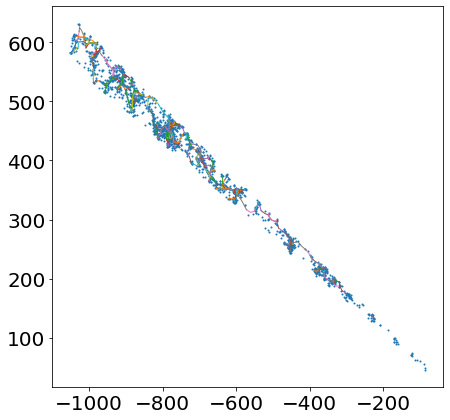

p_web_rosette_1.csv

reading ../../alignment_cw/data/p_web_rosette_1_xyz.txt (ASCII) ... done. (3304 lines)
Margin set to 0.0537139 (actual size is ~60.3853).
Tesselating 3304 particles (3D) ... (+0 in boundary) done. (0.04s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (258 guards):  tesselation ...  generating ... cleaning up ... done. (+19918 particles)
Adding 19918 particles ... done.
Computing density ... done.
All done in 0.55 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_1_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_1_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 5847 vertices.
   periodicity: non-periodic.
   Available faces: 38910 1-F, 63704 2-F, 28445 3-F.
   Bounding box: x0=[-1208.87,-27.878,-37.463],
                 delta=[1124.2,71.68,72.2238].
   Available fields: 'field_value'(0), '

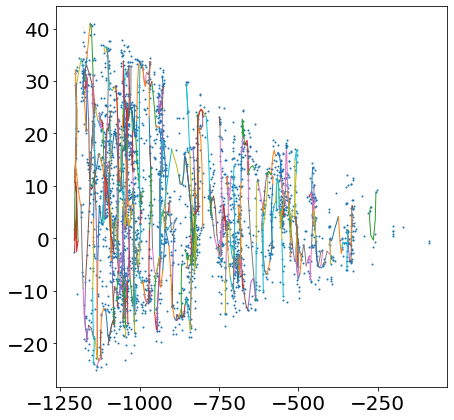

p_web_rosette_2.csv

reading ../../alignment_cw/data/p_web_rosette_2_xyz.txt (ASCII) ... done. (2602 lines)
Margin set to 0.0669959 (actual size is ~75.5391).
Tesselating 2602 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (210 guards):  tesselation ...  generating ... cleaning up ... done. (+26950 particles)
Adding 26950 particles ... done.
Computing density ... done.
All done in 0.44 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_2_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_2_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4750 vertices.
   periodicity: non-periodic.
   Available faces: 31329 1-F, 51092 2-F, 22708 3-F.
   Bounding box: x0=[-1212.11,-104.498,-37.9789],
                 delta=[1127.52,103.8,76.6638].
   Available fields: 'field_value'(0)

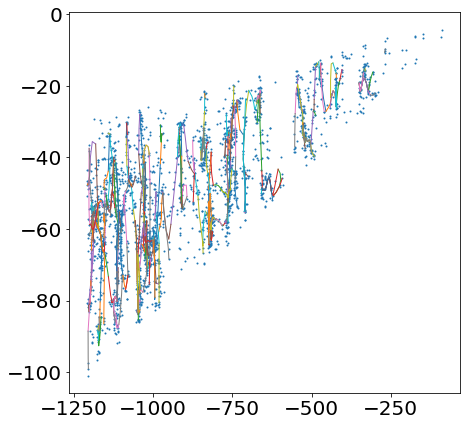

p_web_rosette_3.csv

reading ../../alignment_cw/data/p_web_rosette_3_xyz.txt (ASCII) ... done. (2616 lines)
Margin set to 0.153886 (actual size is ~146.571).
Tesselating 2616 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (132 guards):  tesselation ...  generating ... cleaning up ... done. (+74180 particles)
Adding 74180 particles ... done.
Computing density ... done.
All done in 1.29 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_3_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_3_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4626 vertices.
   periodicity: non-periodic.
   Available faces: 30843 1-F, 50471 2-F, 22651 3-F.
   Bounding box: x0=[-593.949,-138.232,135.38],
                 delta=[522.534,132.407,952.467].
   Available fields: 'field_value'(0),

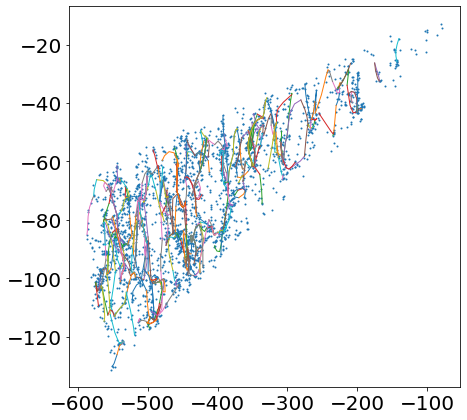

p_web_rosette_4.csv

reading ../../alignment_cw/data/p_web_rosette_4_xyz.txt (ASCII) ... done. (2908 lines)
Margin set to 0.194521 (actual size is ~195.434).
Tesselating 2908 particles (3D) ... (+0 in boundary) done. (0.05s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (122 guards):  tesselation ...  generating ... cleaning up ... done. (+767892 particles)
Adding 767892 particles ... done.
Computing density ... done.
All done in 13.51 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_4_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_4_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 5008 vertices.
   periodicity: non-periodic.
   Available faces: 33360 1-F, 54681 2-F, 24549 3-F.
   Bounding box: x0=[-1056.65,-304.727,24.4212],
                 delta=[1004.7,297.425,581.13].
   Available fields: 'field_value'(0

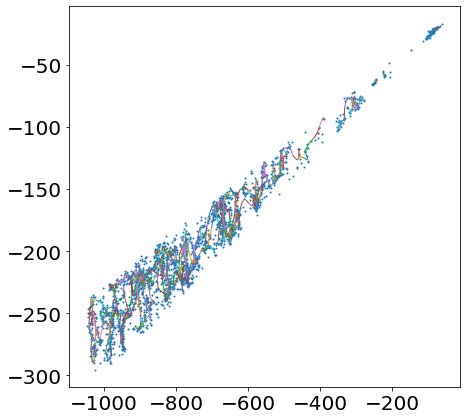

p_web_rosette_5.csv

reading ../../alignment_cw/data/p_web_rosette_5_xyz.txt (ASCII) ... done. (2632 lines)
Margin set to 0.159897 (actual size is ~162.102).
Tesselating 2632 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (132 guards):  tesselation ...  generating ... cleaning up ... done. (+108015 particles)
Adding 108015 particles ... done.
Computing density ... done.
All done in 1.64 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_5_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_5_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4609 vertices.
   periodicity: non-periodic.
   Available faces: 30539 1-F, 49941 2-F, 22484 3-F.
   Bounding box: x0=[-1060.09,-631.506,-0.961836],
                 delta=[1013.79,608.579,145.371].
   Available fields: 'field_value

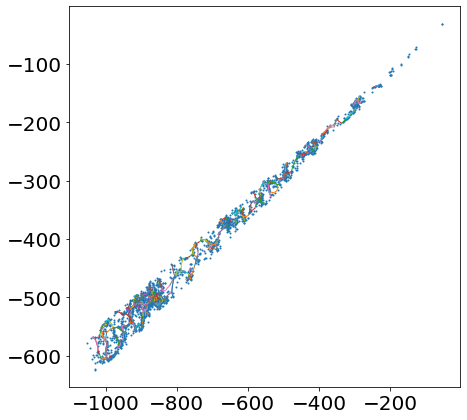

p_web_rosette_6.csv

reading ../../alignment_cw/data/p_web_rosette_6_xyz.txt (ASCII) ... done. (2149 lines)
Margin set to 0.261948 (actual size is ~236.397).
Tesselating 2149 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (94 guards):  tesselation ...  generating ... cleaning up ... done. (+198111 particles)
Adding 198111 particles ... done.
Computing density ... done.
All done in 3.79 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_6_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_6_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 3862 vertices.
   periodicity: non-periodic.
   Available faces: 25304 1-F, 41168 2-F, 18470 3-F.
   Bounding box: x0=[-631.824,-466.902,87.366],
                 delta=[580.04,433.877,902.456].
   Available fields: 'field_value'(0),

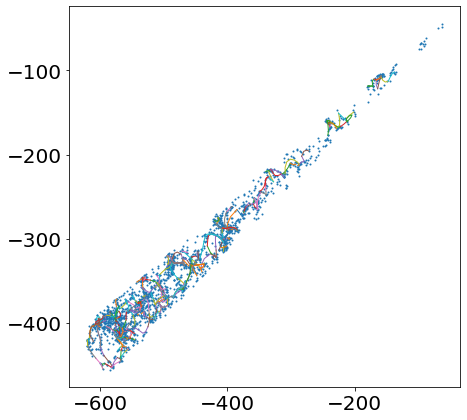

p_web_rosette_7.csv

reading ../../alignment_cw/data/p_web_rosette_7_xyz.txt (ASCII) ... done. (2314 lines)
Margin set to 0.333108 (actual size is ~269.157).
Tesselating 2314 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (112 guards):  tesselation ...  generating ... cleaning up ... done. (+393116 particles)
Adding 393116 particles ... done.
Computing density ... done.
All done in 6.79 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_7_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_7_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4160 vertices.
   periodicity: non-periodic.
   Available faces: 27301 1-F, 44497 2-F, 20020 3-F.
   Bounding box: x0=[-824.498,-644.66,13.3743],
                 delta=[808.015,634.942,703.582].
   Available fields: 'field_value'(0

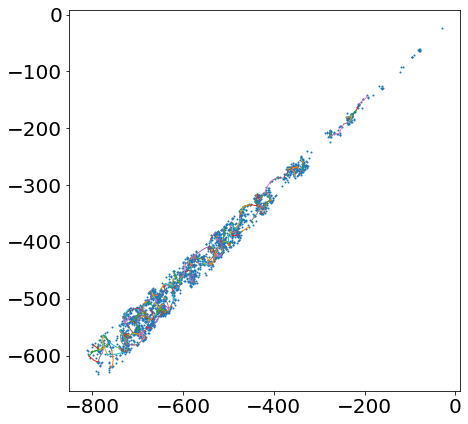

p_web_rosette_8.csv

reading ../../alignment_cw/data/p_web_rosette_8_xyz.txt (ASCII) ... done. (2677 lines)
Margin set to 0.147582 (actual size is ~132.567).
Tesselating 2677 particles (3D) ... (+0 in boundary) done. (0.04s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (172 guards):  tesselation ...  generating ... cleaning up ... done. (+62940 particles)
Adding 62940 particles ... done.
Computing density ... done.
All done in 1.54 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_8_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_8_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4692 vertices.
   periodicity: non-periodic.
   Available faces: 31094 1-F, 50835 2-F, 22936 3-F.
   Bounding box: x0=[-996.315,-748.281,-53.089],
                 delta=[898.263,677.288,82.0108].
   Available fields: 'field_value'(0)

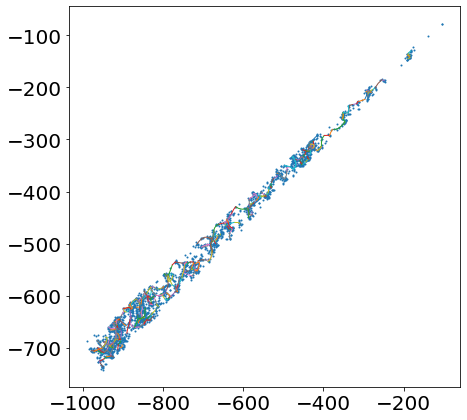

p_web_rosette_9.csv

reading ../../alignment_cw/data/p_web_rosette_9_xyz.txt (ASCII) ... done. (2967 lines)
Margin set to 0.148792 (actual size is ~127.921).
Tesselating 2967 particles (3D) ... (+0 in boundary) done. (0.05s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (172 guards):  tesselation ...  generating ... cleaning up ... done. (+82059 particles)
Adding 82059 particles ... done.
Computing density ... done.
All done in 1.57 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_9_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_9_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 5035 vertices.
   periodicity: non-periodic.
   Available faces: 33654 1-F, 55220 2-F, 24922 3-F.
   Bounding box: x0=[-952.456,-802.19,-52.8053],
                 delta=[859.728,728.425,79.3386].
   Available fields: 'field_value'(0)

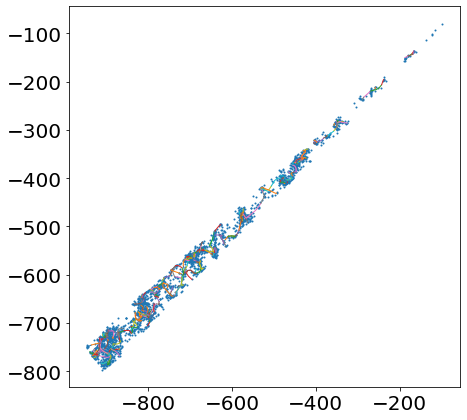

p_web_rosette_10.csv

reading ../../alignment_cw/data/p_web_rosette_10_xyz.txt (ASCII) ... done. (2667 lines)
Margin set to 0.158393 (actual size is ~143.004).
Tesselating 2667 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (172 guards):  tesselation ...  generating ... cleaning up ... done. (+139114 particles)
Adding 139114 particles ... done.
Computing density ... done.
All done in 3.08 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_10_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_10_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4711 vertices.
   periodicity: non-periodic.
   Available faces: 31215 1-F, 51032 2-F, 22944 3-F.
   Bounding box: x0=[-977.566,-776.788,-4.57879],
                 delta=[902.846,722.365,95.6727].
   Available fields: 'field_va

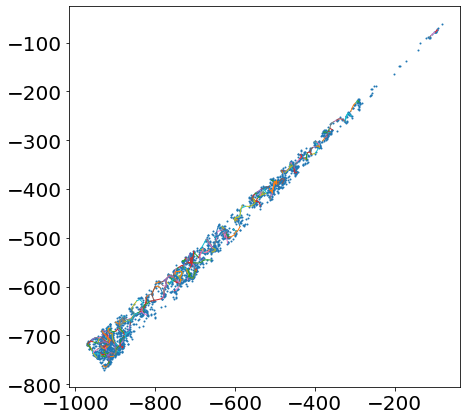

p_web_rosette_11.csv

reading ../../alignment_cw/data/p_web_rosette_11_xyz.txt (ASCII) ... done. (3237 lines)
Margin set to 0.20842 (actual size is ~200.711).
Tesselating 3237 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (126 guards):  tesselation ...  generating ... cleaning up ... done. (+242485 particles)
Adding 242485 particles ... done.
Computing density ... done.
All done in 5.32 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_11_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_11_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 5406 vertices.
   periodicity: non-periodic.
   Available faces: 35996 1-F, 59064 2-F, 26807 3-F.
   Bounding box: x0=[-359.246,-649.652,52.6681],
                 delta=[350.827,619.755,963.011].
   Available fields: 'field_valu

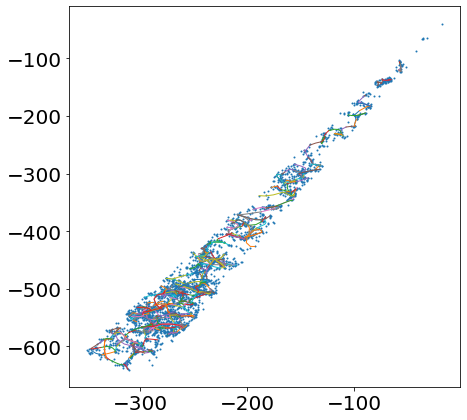

p_web_rosette_12.csv

reading ../../alignment_cw/data/p_web_rosette_12_xyz.txt (ASCII) ... done. (2506 lines)
Margin set to 0.293336 (actual size is ~236.008).
Tesselating 2506 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (110 guards):  tesselation ...  generating ... cleaning up ... done. (+346111 particles)
Adding 346111 particles ... done.
Computing density ... done.
All done in 5.37 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_12_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_12_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4375 vertices.
   periodicity: non-periodic.
   Available faces: 28899 1-F, 47200 2-F, 21291 3-F.
   Bounding box: x0=[-464.974,-802.644,60.2043],
                 delta=[438.518,746.97,804.566].
   Available fields: 'field_valu

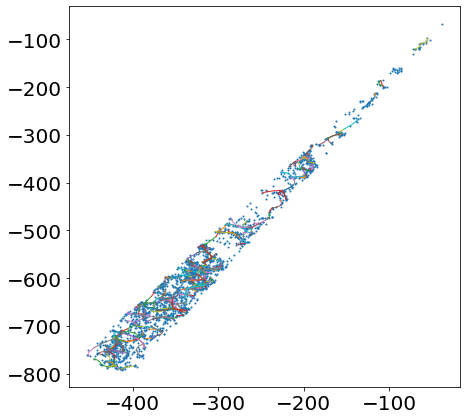

p_web_rosette_13.csv

reading ../../alignment_cw/data/p_web_rosette_13_xyz.txt (ASCII) ... done. (3565 lines)
Margin set to 0.250557 (actual size is ~196.082).
Tesselating 3565 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (110 guards):  tesselation ...  generating ... cleaning up ... done. (+672262 particles)
Adding 672262 particles ... done.
Computing density ... done.
All done in 9.99 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_13_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_13_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 5750 vertices.
   periodicity: non-periodic.
   Available faces: 38870 1-F, 64114 2-F, 29175 3-F.
   Bounding box: x0=[-398.111,-822.519,81.0165],
                 delta=[370.306,741.942,782.584].
   Available fields: 'field_val

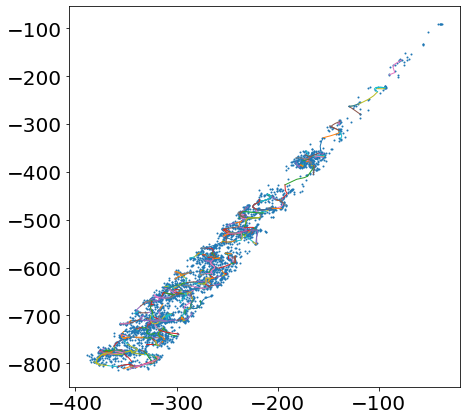

p_web_rosette_14.csv

reading ../../alignment_cw/data/p_web_rosette_14_xyz.txt (ASCII) ... done. (2073 lines)
Margin set to 0.252309 (actual size is ~223.893).
Tesselating 2073 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (94 guards):  tesselation ...  generating ... cleaning up ... done. (+302113 particles)
Adding 302113 particles ... done.
Computing density ... done.
All done in 4.08 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_14_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_14_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 3948 vertices.
   periodicity: non-periodic.
   Available faces: 25672 1-F, 41585 2-F, 18441 3-F.
   Bounding box: x0=[-337.797,-975.535,63.5367],
                 delta=[318.5,887.376,658.559].
   Available fields: 'field_value'

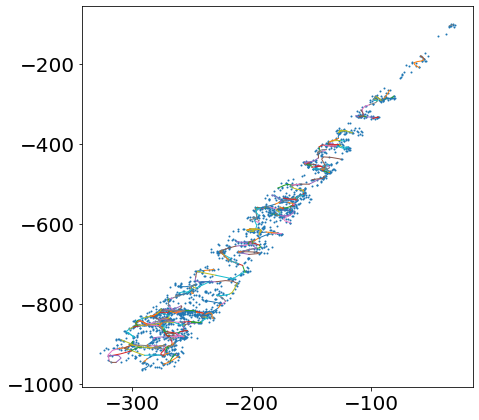

p_web_rosette_15.csv

reading ../../alignment_cw/data/p_web_rosette_15_xyz.txt (ASCII) ... done. (2151 lines)
Margin set to 0.128007 (actual size is ~131.581).
Tesselating 2151 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (146 guards):  tesselation ...  generating ... cleaning up ... done. (+80769 particles)
Adding 80769 particles ... done.
Computing density ... done.
All done in 1.09 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_15_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_15_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4058 vertices.
   periodicity: non-periodic.
   Available faces: 26611 1-F, 43274 2-F, 19097 3-F.
   Bounding box: x0=[-42.2204,-519.937,94.8101],
                 delta=[79.0654,482.35,1027.92].
   Available fields: 'field_value'

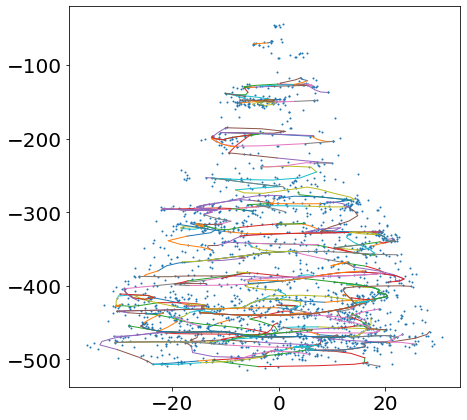

p_web_rosette_16.csv

reading ../../alignment_cw/data/p_web_rosette_16_xyz.txt (ASCII) ... done. (2929 lines)
Margin set to 0.186798 (actual size is ~190.171).
Tesselating 2929 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (122 guards):  tesselation ...  generating ... cleaning up ... done. (+129239 particles)
Adding 129239 particles ... done.
Computing density ... done.
All done in 1.82 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_16_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_16_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4670 vertices.
   periodicity: non-periodic.
   Available faces: 31519 1-F, 51999 2-F, 23869 3-F.
   Bounding box: x0=[-1082.49,-317.164,28.5824],
                 delta=[1018.06,307.211,515.269].
   Available fields: 'field_val

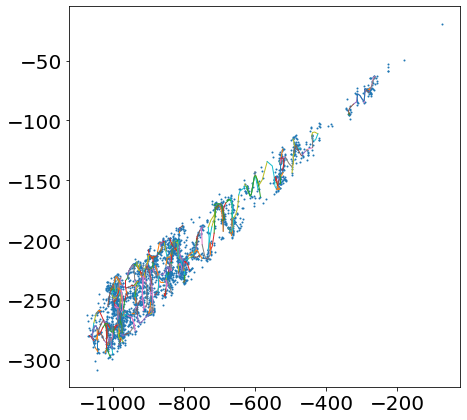

p_web_rosette_17.csv

reading ../../alignment_cw/data/p_web_rosette_17_xyz.txt (ASCII) ... done. (2714 lines)
Margin set to 0.1381 (actual size is ~131.346).
Tesselating 2714 particles (3D) ... (+0 in boundary) done. (0.03s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (168 guards):  tesselation ...  generating ... cleaning up ... done. (+77740 particles)
Adding 77740 particles ... done.
Computing density ... done.
All done in 1.18 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_17_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_17_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4704 vertices.
   periodicity: non-periodic.
   Available faces: 31249 1-F, 51162 2-F, 23008 3-F.
   Bounding box: x0=[-1034.77,-686.424,-53.185],
                 delta=[951.091,638.135,81.0616].
   Available fields: 'field_value'(

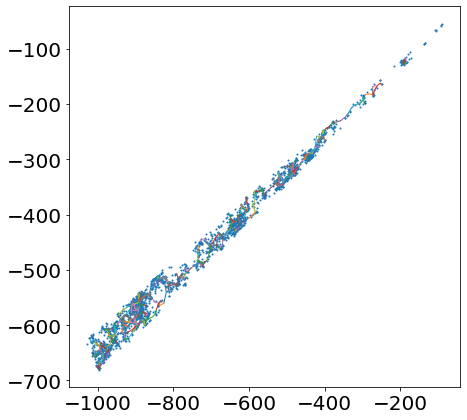

p_web_rosette_18.csv

reading ../../alignment_cw/data/p_web_rosette_18_xyz.txt (ASCII) ... done. (2188 lines)
Margin set to 0.133796 (actual size is ~136.882).
Tesselating 2188 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (168 guards):  tesselation ...  generating ... cleaning up ... done. (+68698 particles)
Adding 68698 particles ... done.
Computing density ... done.
All done in 0.99 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_18_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_18_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 4055 vertices.
   periodicity: non-periodic.
   Available faces: 26457 1-F, 42949 2-F, 19033 3-F.
   Bounding box: x0=[-42.4755,-586.118,71.132],
                 delta=[79.7097,550.508,1023.07].
   Available fields: 'field_value'

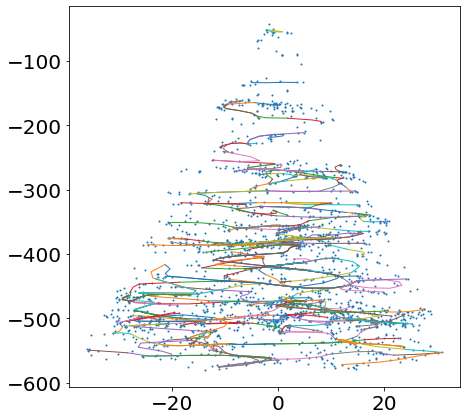

p_web_rosette_19.csv

reading ../../alignment_cw/data/p_web_rosette_19_xyz.txt (ASCII) ... done. (2266 lines)
Margin set to 0.312483 (actual size is ~254.223).
Tesselating 2266 particles (3D) ... (+0 in boundary) done. (0.02s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (94 guards):  tesselation ...  generating ... cleaning up ... done. (+758690 particles)
Adding 758690 particles ... done.
Computing density ... done.
All done in 11.20 s.
Converting tesselation to NDnetwork ... done.
Will write network to file '../../alignment_cw/data/p_web_rosette_19_xyz.txt.NDnet'.
All done.

Network was saved as : ../../alignment_cw/data/p_web_rosette_19_xyz.txt.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 3993 vertices.
   periodicity: non-periodic.
   Available faces: 26335 1-F, 42999 2-F, 19400 3-F.
   Bounding box: x0=[-529.114,-756.461,42.9596],
                 delta=[507.353,721.601,813.56].
   Available fields: 'field_valu

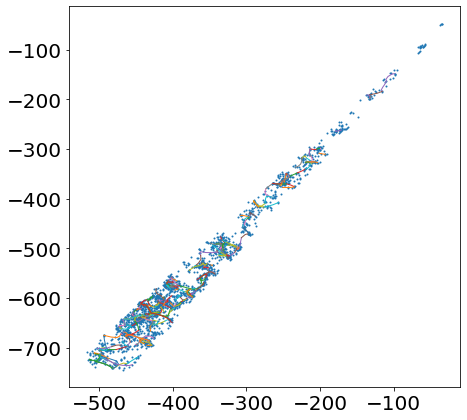

In [5]:
fig = pl.figure()
for i in range(20):
    file = f'p_web_rosette_{i}.csv'
    print(file)
    df = pd.read_csv(f'{path}/{file}')
    X,Y,Z = radecz2xyz(df['RA'], df['DEC'], df['Z'])
    compute_disperse(file)
    _ = create_filaments_file(file)
    pl.scatter(X,Y, s=1)
    pl.show()